# **Lab 4.2 NN MLP and CNN**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [2]:
def load_data(path,class_names):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(45, fill=255),  # Random rotation for augmentation
        transforms.Pad(padding=2, fill=255, padding_mode='constant'),  # Padding to ensure the image size is 32x32 if needed, fill white
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor()
    ])
    
    # Load dataset with all classes (0-9)
    full_dataset = ImageFolder(root=path, transform=transform)
    
    # Get class indices for specified class names
    class_to_idx = full_dataset.class_to_idx
    selected_class_indices = [class_to_idx[c] for c in class_names]

    # Filter dataset to only keep samples of the selected classes
    filtered_indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_class_indices]
    filtered_dataset = Subset(full_dataset, filtered_indices)

    # Optional: Split into train and test sets (80/20 split)
    train_size = int(0.8 * len(filtered_dataset))
    test_size = len(filtered_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(filtered_dataset, [train_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Print dataset information
    print(f"Total samples: {len(filtered_dataset)}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Classes loaded: {class_names}")

    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

Total samples: 776
Train samples: 620
Test samples: 156
Classes loaded: ['5', '7']


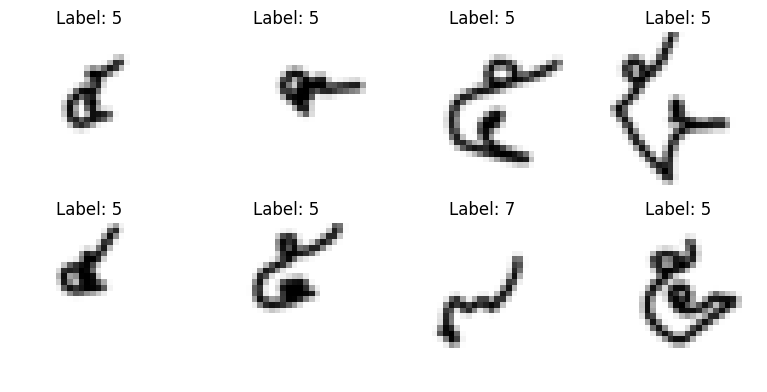

In [132]:
### START CODE HERE ###
path = './thai-handwriting-number.appspot.com'  # Replace with your dataset path
class_names = ['5', '7']  # Specify the class names you want to load
train_loader, test_loader = load_data(path, class_names)

# Display the first batch of images
images, labels = next(iter(train_loader))
plt.figure(figsize=(8, 4))
for i in range(min(8, images.size(0))):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
# class_names = None
# train_loader, test_loader = load_data(None,class_names)



### END CODE HERE ###

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

In [2]:
### START CODE HERE ###
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc = nn.Linear(28 * 28, 1)
        self.sigmoid = nn.Sigmoid()

    # Get Result from all Layers
    def get_features(self,inp):
        # Flatten the image and pass through FC layer with sigmoid activation
        x = inp.view(inp.size(0), -1)      # Flatten to (batch_size, 784)
        out = self.sigmoid(self.fc(x))  # Apply sigmoid activation
        return inp, out

    def forward(self, x):
        # Flatten the image and pass through FC layer with sigmoid activation
        x = x.view(x.size(0), -1)      # Flatten to (batch_size, 784)
        x = self.sigmoid(self.fc(x))  # Apply sigmoid activation
        return x
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 16)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid2 = nn.Sigmoid()
    
    def get_features(self,inp):
        x = inp.view(inp.size(0), -1)          # Flatten the input
        out1 = self.sigmoid1(self.fc1(x)) # Output from first layer
        out2 = self.sigmoid2(self.fc2(out1)) # Output from second layer
        return inp, out1, out2

    def forward(self, x):
        features = self.get_features(x)
        return features[-1]  # Return the final output (sigmoid of second layer)
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the CNN architecture
        #fist create 2 convolutional layers with ReLU activation
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()

        #flatten the output of the last convolutional layer
        self.flatten = nn.Flatten()
        #create 2 fully connected layers with ReLU activation
        self.fc1 = nn.Linear(32*7*7, 100)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
    
    def get_features(self,x):
        x1 = self.pool1(self.relu1(self.conv1(x)))  # shape: [B, 16, 14, 14]
        # Feature map after second conv + relu + pool
        x2 = self.pool2(self.relu2(self.conv2(x1)))  # shape: [B, 32, 7, 7]
        # Flatten for FC layers
        x_flat = self.flatten(x2)
        # Fully connected layer 1 + ReLU
        x3 = self.relu_fc1(self.fc1(x_flat))  # shape: [B, 128]
        # Output layer + sigmoid
        x4 = self.sigmoid(self.fc2(x3))  # shape: [B, 1]

        return x, x1, x2, x3, x4

    def forward(self, x):
        features = self.get_features(x)
        return features[-1]

### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [96]:
def show_NN_featuremaps(feat):
    image = feat.unsqueeze(0).detach().cpu().numpy()
    #flatten images and display as heatmap
    flatten_image_arr = image.flatten()
    #craete np array size of 29*size 0f flatten image
    flatten_image = np.tile(flatten_image_arr, (28, 1)).transpose()
    plt.figure(figsize=(1,8))
    sns.heatmap(flatten_image, cmap='viridis', cbar=True)
    plt.title("First Image from First Batch (Heatmap)")
    plt.axis('off')
    plt.show()

def show_MLP_featuremaps(feat):
    image = feat.unsqueeze(0).detach().cpu().numpy()
    #flatten images and display as heatmap
    flatten_image_arr = image.flatten()
    #craete np array size of 29*size 0f flatten image
    flatten_image = np.tile(flatten_image_arr, (16, 1)).transpose()
    plt.figure(figsize=(1,8))
    sns.heatmap(flatten_image, cmap='viridis', cbar=True)
    plt.title("First Image from First Batch (Heatmap)")
    plt.axis('off')
    plt.show()
    
def show_CNN_featuremaps(feat):
    feat_img = feat.squeze(0).view(-1,14).detach().numpy()
    plt.figure(figsize=(1,8))
    sns.heatmap(feat_img, cmap='viridis', cbar=True)
    plt.axis('off')
    plt.title("Reshaped Image (14 x 16*14)")
    plt.show()

def show_featuremaps(feat):
    ### START CODE HERE ###
    pass
    ### END CODE HERE ###

TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [ ]:
def to_binary(labels, class_names):
    return (labels == int(class_names[1])).float()

def train(class_names, model, opt, loss_fn, train_loader, test_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    ### START CODE HERE ###
    model.to(device)
    scaler = GradScaler(device=device)
    for epoch in range(epochs):
        model.train()
        correct, total = 0,0
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), torch.squeeze(labels).to(device)
            #turn labels from class index to binary (0 or 1)
            binary_labels = to_binary(labels, class_names).view(-1,1)
            opt.zero_grad()

            labels = labels.float().view(-1, 1)  # Ensure labels are of shape (batch_size, 1)
            with autocast(device_type=device):
                output = model(images)
                loss = loss_fn(output, binary_labels)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            pred = output.view(-1).round()
            correct += (pred == binary_labels.view(-1)).sum().item()
            total += binary_labels.size(0)

        avg_train_loss = running_loss / total
        train_acc = correct / total

        # Log loss to TensorBoard
        # if epoch % 10 == 0 and writer is not None:
        #     writer.add_scalar('Loss/train', running_loss / len(train_loader), epoch)

        # Evaluation
        model.eval()
        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), torch.squeeze(labels).to(device)
                binary_labels = to_binary(labels, class_names)
                outputs = model(images)
                predicted = outputs.round()  # If this is a binary classification, round the output
                total_samples += binary_labels.size(0)
                total_correct += (predicted.view(-1) == binary_labels).sum().item()
            
            accuracy =  total_correct / total_samples
            avg_test_loss = running_loss / total_samples

            #use writer to log accuracy for TensorBoard
            if writer:
                writer.add_scalar('Loss/train', avg_train_loss, epoch)
                writer.add_scalar('Loss/test', avg_test_loss, epoch)
                writer.add_scalar('Acc/train', train_acc, epoch)
                writer.add_scalar('Acc/test', accuracy, epoch)
                
    print(f"Validation Accuracy: {accuracy*100}%")

            # Forward pass
    # Save model
    if checkpoint_path is not None:
        torch.save(model.state_dict(), checkpoint_path)
    ### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [136]:
### START CODE HERE ###
nn_model = NN()
nn_opt = torch.optim.Adam(nn_model.parameters(), lr=0.001)
nn_loss_fn = nn.MSELoss()
writer = SummaryWriter(log_dir="runs/NN")  # Initialize TensorBoard writer
train(class_names, nn_model, nn_opt, nn_loss_fn, train_loader, test_loader, epochs=10,writer= writer, device='cpu')
writer.close()


### END CODE HERE ###

Epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 20.49it/s]


Validation Accuracy: 47.43589743589743%


Epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 21.37it/s]


Validation Accuracy: 58.333333333333336%


Epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 22.12it/s]


Validation Accuracy: 58.333333333333336%


Epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


Validation Accuracy: 48.07692307692308%


Epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 22.65it/s]


Validation Accuracy: 73.71794871794873%


Epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 22.99it/s]


Validation Accuracy: 78.2051282051282%


Epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Validation Accuracy: 75.64102564102564%


Epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Validation Accuracy: 75.0%


Epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 20.10it/s]


Validation Accuracy: 79.48717948717949%


Epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 22.99it/s]


Validation Accuracy: 80.12820512820514%


In [99]:
feats = nn_model.get_features(images[0].unsqueeze(0).to('cpu'))

In [106]:
feats[0].squeeze().detach().cpu().numpy().shape

(28, 28)

In [137]:
MLP_model = MLP()
mlp_opt = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
mlp_loss_fn = nn.MSELoss()
writer = SummaryWriter(log_dir="runs/MLP")  # Initialize TensorBoard writer
train(class_names, MLP_model, mlp_opt, mlp_loss_fn, train_loader, test_loader, epochs=10,writer = writer, device='cpu')

Epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 21.36it/s]


Validation Accuracy: 47.43589743589743%


Epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 21.59it/s]


Validation Accuracy: 53.205128205128204%


Epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 22.21it/s]


Validation Accuracy: 48.717948717948715%


Epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 21.68it/s]


Validation Accuracy: 53.84615384615385%


Epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 22.21it/s]


Validation Accuracy: 75.64102564102564%


Epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 21.36it/s]


Validation Accuracy: 78.84615384615384%


Epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 22.17it/s]


Validation Accuracy: 76.92307692307693%


Epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 21.83it/s]


Validation Accuracy: 73.71794871794873%


Epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 21.60it/s]


Validation Accuracy: 83.97435897435898%


Epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 21.16it/s]


Validation Accuracy: 75.64102564102564%


In [21]:
feats = MLP_model.get_features(images[0].unsqueeze(0).to('cpu'))

In [ ]:
show_MLP_featuremaps(feats[0])

In [138]:
CNN_model = CNN()
cnn_opt = torch.optim.Adam(CNN_model.parameters(), lr=0.001)
cnn_loss_fn = nn.MSELoss()
writer = SummaryWriter(log_dir='runs/CNN')  # Initialize TensorBoard writer
train(class_names, CNN_model, cnn_opt, cnn_loss_fn, train_loader, test_loader, epochs=10,writer=writer, device='cpu')

Epoch 1/10: 100%|██████████| 20/20 [00:01<00:00, 13.78it/s]


Validation Accuracy: 79.48717948717949%


Epoch 2/10: 100%|██████████| 20/20 [00:01<00:00, 13.34it/s]


Validation Accuracy: 76.92307692307693%


Epoch 3/10: 100%|██████████| 20/20 [00:01<00:00, 13.69it/s]


Validation Accuracy: 76.92307692307693%


Epoch 4/10: 100%|██████████| 20/20 [00:01<00:00, 13.21it/s]


Validation Accuracy: 76.92307692307693%


Epoch 5/10: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Validation Accuracy: 81.41025641025641%


Epoch 6/10: 100%|██████████| 20/20 [00:01<00:00, 13.33it/s]


Validation Accuracy: 87.17948717948718%


Epoch 7/10: 100%|██████████| 20/20 [00:01<00:00, 13.24it/s]


Validation Accuracy: 87.17948717948718%


Epoch 8/10: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Validation Accuracy: 91.02564102564102%


Epoch 9/10: 100%|██████████| 20/20 [00:01<00:00, 13.49it/s]


Validation Accuracy: 90.38461538461539%


Epoch 10/10: 100%|██████████| 20/20 [00:01<00:00, 13.51it/s]


Validation Accuracy: 89.74358974358975%


In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(45, fill=255),  # Random rotation for augmentation
    transforms.Pad(padding=2, fill=255, padding_mode='constant'),  # Padding to ensure the image size is 32x32 if needed, fill white
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor()
])

# Load dataset with all classes (0-9)
full_dataset = ImageFolder(root='./thai-handwriting-number.appspot.com', transform=transform)

In [5]:
def select_classes(full_dataset, class_names):
    # Get class indices for specified class names
    class_to_idx = full_dataset.class_to_idx
    selected_class_indices = [class_to_idx[c] for c in class_names]

    # Filter dataset to only keep samples of the selected classes
    filtered_indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_class_indices]
    filtered_dataset = Subset(full_dataset, filtered_indices)

    # Optional: Split into train and test sets (80/20 split)
    train_size = int(0.8 * len(filtered_dataset))
    test_size = len(filtered_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(filtered_dataset, [train_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader

In [ ]:
# for i in range(9):
#     for j in range(i+1,10):
#         class_names = [str(i), str(j)]
#         train_loader, test_loader = select_classes(full_dataset, class_names)
#         NN_model = NN()
#         nn_opt = torch.optim.Adam(NN_model.parameters(), lr=0.001)
#         nn_loss_fn = nn.MSELoss()
#         writer = SummaryWriter(log_dir=f'runs/Combination/NN/NN_{i}_{j}')
#         train(class_names, NN_model, nn_opt, nn_loss_fn, train_loader, test_loader, epochs=10,writer=writer, device='cpu')
#         checkpoint_path = f'models/NN/NN_{class_names[0]}_{class_names[1]}.pth'
#         torch.save(NN_model.state_dict(), checkpoint_path)
#         writer.close()
#         del NN_model, nn_opt, nn_loss_fn, train_loader, test_loader, writer

In [ ]:
#save models
# import os
# for class_names, model in Model_list:
#     os.makedirs('models', exist_ok=True)  # Ensure the models directory exists
#     checkpoint_path = f'models/CNN_{class_names[0]}_{class_names[1]}.pth'
#     torch.save(model.state_dict(), checkpoint_path)
#     print(f"Model for classes {class_names} saved to {checkpoint_path}")

Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>

In [10]:
### START CODE HERE ###
from sklearn.metrics import confusion_matrix
def sumnmary_confusion_matrix(model, test_loader,class_names, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.round()  # Assuming binary classification
            binary_labels = to_binary(labels, class_names).view(-1,1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(binary_labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    

    cm = confusion_matrix(all_labels, all_preds)

    return cm
### END CODE HERE ###

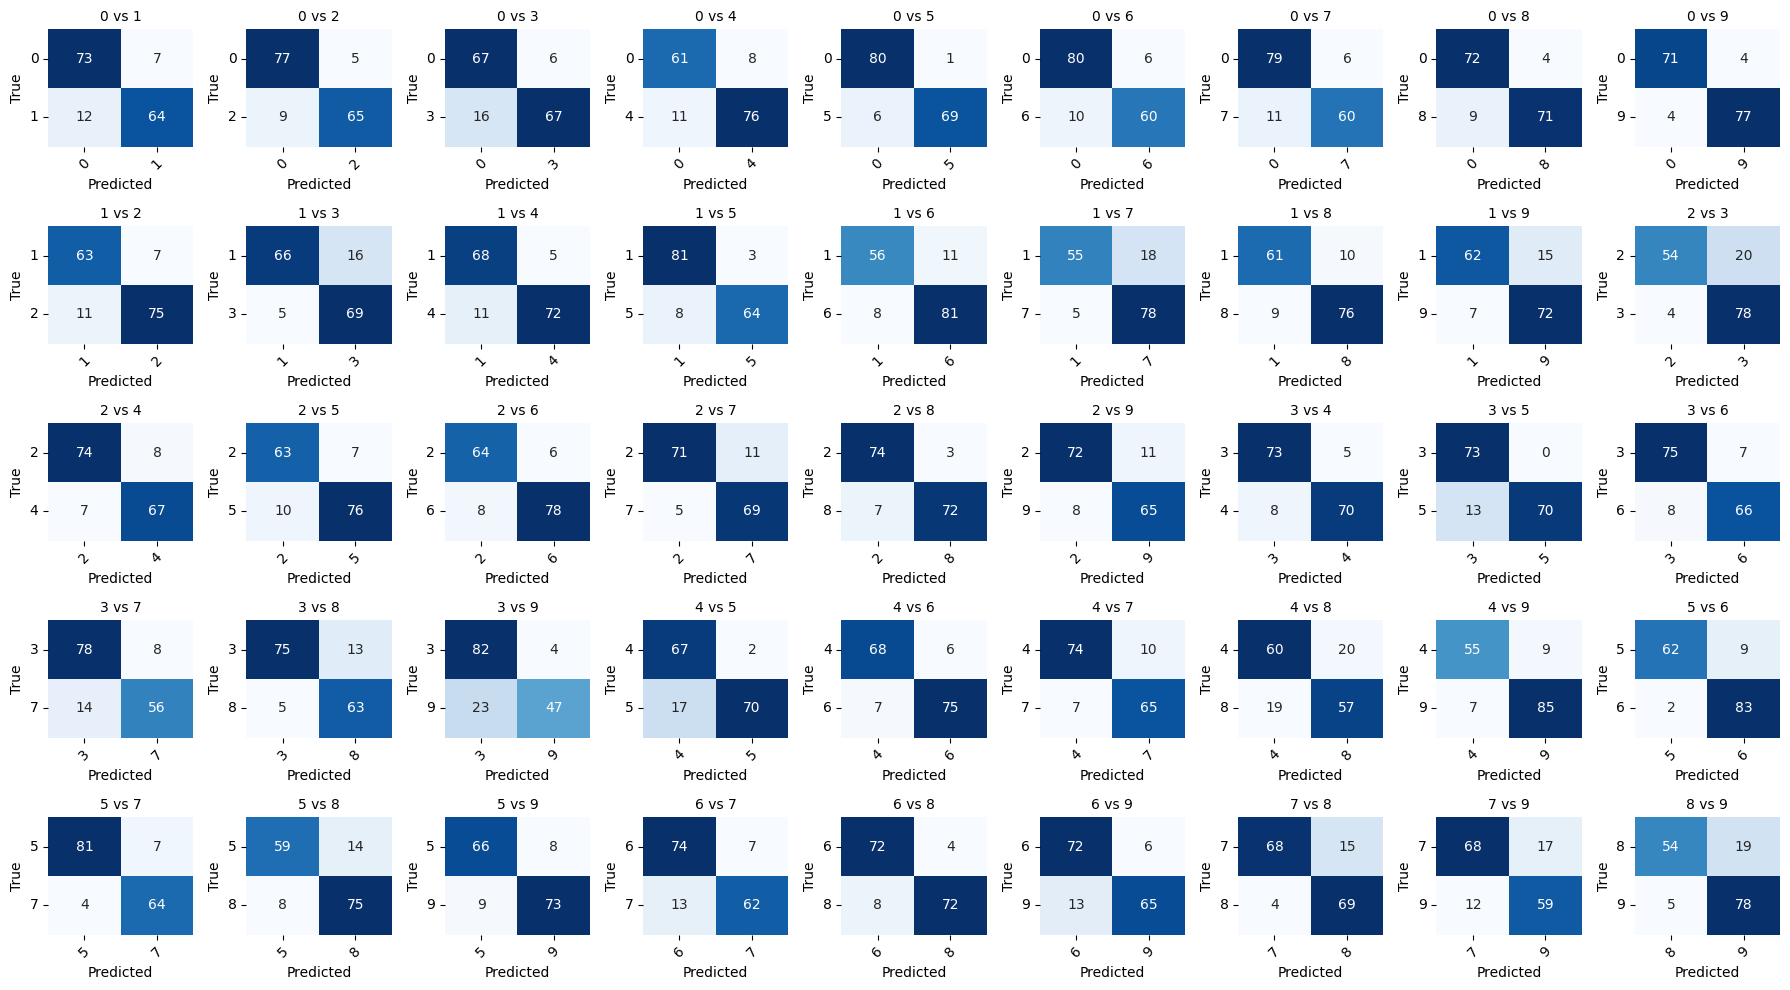

In [8]:
# sumnmary_confusion_matrix(CNN_model, test_loader, device='cpu', class_names=class_names)
#create subplot that have 9 columns and 5 rows
fig, axes = plt.subplots(5, 9, figsize=(18, 10))  # 5 rows × 9 cols = 45 subplots
axes = axes.flatten()  # Flatten to 1D for easier indexing

k = 0  # subplot index

for i in range(9):
    for j in range(i+1, 10):
        class_names = [str(i), str(j)]
        path = f"models/CNN_{class_names[0]}_{class_names[1]}.pth"

        CNN_model = CNN()
        CNN_model.load_state_dict(torch.load(path, map_location='cpu'))
        CNN_model.eval()

        train_loader, test_loader = select_classes(full_dataset, class_names)
        cm = sumnmary_confusion_matrix(CNN_model, test_loader, class_names=class_names, device='cpu')

        ax = axes[k]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    ax=ax, cbar=False)

        ax.set_title(f'{class_names[0]} vs {class_names[1]}', fontsize=10)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

        k += 1

plt.tight_layout()
plt.show()

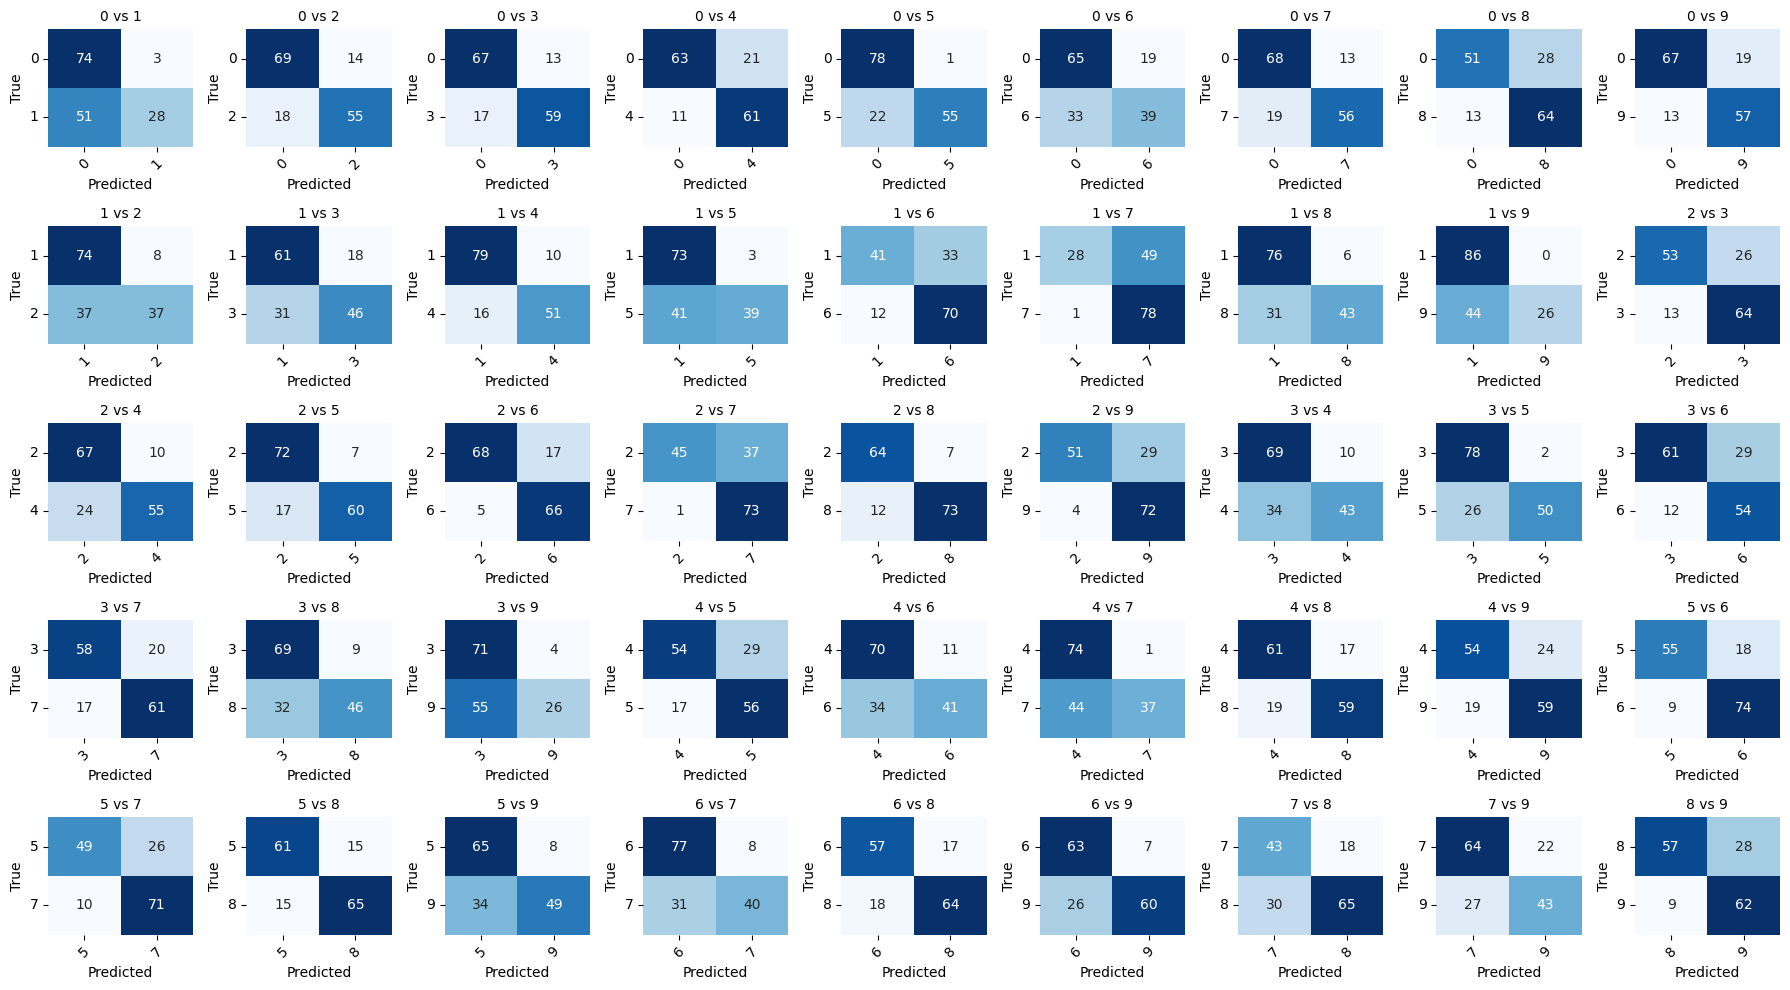

In [11]:
# sumnmary_confusion_matrix(CNN_model, test_loader, device='cpu', class_names=class_names)
#create subplot that have 9 columns and 5 rows
fig, axes = plt.subplots(5, 9, figsize=(18, 10))  # 5 rows × 9 cols = 45 subplots
axes = axes.flatten()  # Flatten to 1D for easier indexing

k = 0  # subplot index

for i in range(9):
    for j in range(i+1, 10):
        class_names = [str(i), str(j)]
        path = f"models/NN/NN_{class_names[0]}_{class_names[1]}.pth"

        NN_model = NN()
        NN_model.load_state_dict(torch.load(path, map_location='cpu'))
        NN_model.eval()

        train_loader, test_loader = select_classes(full_dataset, class_names)
        cm = sumnmary_confusion_matrix(NN_model, test_loader, class_names=class_names, device='cpu')

        ax = axes[k]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    ax=ax, cbar=False)

        ax.set_title(f'{class_names[0]} vs {class_names[1]}', fontsize=10)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

        k += 1
        del NN_model, train_loader, test_loader, cm

plt.tight_layout()
plt.show()

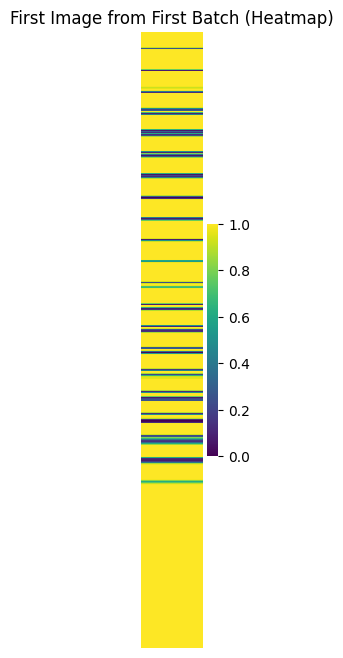

In [ ]:
# Get the first image from the first batch
first_image = images[1].unsqueeze(0).detach().cpu().numpy()
#flatten images and display as heatmap
flatten_image_arr = first_image.flatten()
#craete np array size of 29*size 0f flatten image
flatten_image = np.tile(flatten_image_arr, (28, 1)).transpose()
plt.figure(figsize=(1,8))
sns.heatmap(flatten_image, cmap='viridis', cbar=True)
plt.title("First Image from First Batch (Heatmap)")
plt.axis('off')
plt.show()
# flatten_image.transpose()

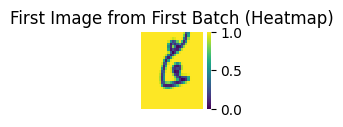

In [25]:
plt.figure(figsize=(1,1))
sns.heatmap(first_image.squeeze(), cmap='viridis', cbar=True)
plt.title("First Image from First Batch (Heatmap)")
plt.axis('off')
plt.show()

In [16]:
def show_NN_featuremaps(feats):
    first_image = feats[0].squeeze().detach().cpu().numpy()
    #craete np array size of 29*size 0f flatten image
    flatten_image = np.tile(first_image.flatten(), (28, 1)).transpose()
    # Create figure
    fig = plt.figure(figsize=(20, 6), facecolor='black')

    # Add first axes: 28x28 image (taller)
    ax1 = fig.add_axes([0.0, 0.37, 0.10, 0.25])  # [left, bottom, width, height]
    sns.heatmap(first_image, ax=ax1, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax1.axis('off')

    # Add second axes: 28x784 image (shorter)
    ax2 = fig.add_axes([0.15, 0.0, 0.10, 1])  # shorter height
    sns.heatmap(flatten_image, ax=ax2, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax2.axis('off')

    ax3 = fig.add_axes([0.30, 0.37, 0.10, 0.25])  # shorter height
    sns.heatmap(np.full((28, 28), feats[1].detach().cpu().numpy()[0]), ax=ax3, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax3.axis('off')

    ax4 = fig.add_axes([0.45, 0.37, 0.10, 0.25])  # shorter height
    sns.heatmap(np.full((28, 28), feats[1].detach().cpu().numpy()[0].round()), ax=ax4, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax4.axis('off')

    return fig

def show_MLP_featuremaps(feats):
    first_image = feats[0].squeeze().detach().cpu().numpy()
    #craete np array size of 29*size 0f flatten image
    flatten_image = np.tile(first_image.flatten(), (28, 1)).transpose()

    layer2 = feats[1].unsqueeze(0).detach().cpu().numpy()
    #craete np array size of 29*size 0f flatten image
    layer2_image = np.tile(layer2.flatten(), (16, 1)).transpose()
    # Create figure
    fig = plt.figure(figsize=(20, 6), facecolor='black')

    # Add first axes: 28x28 image (taller)
    ax1 = fig.add_axes([0.0, 0.37, 0.10, 0.25])  # [left, bottom, width, height]
    sns.heatmap(first_image, ax=ax1, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax1.axis('off')

    # Add second axes: 28x784 image (shorter)
    ax2 = fig.add_axes([0.15, 0.0, 0.10, 1])  # shorter height
    sns.heatmap(flatten_image, ax=ax2, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax2.axis('off')

    ax3 = fig.add_axes([0.30, 0.15, 0.10, 0.7])  # shorter height
    sns.heatmap(layer2_image, ax=ax3, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax3.axis('off')

    ax4 = fig.add_axes([0.45, 0.37, 0.10, 0.25])  # shorter height
    sns.heatmap(np.full((28, 28), feats[2].detach().cpu().numpy()[0]), ax=ax4, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax4.axis('off')

    ax5 = fig.add_axes([0.60, 0.37, 0.10, 0.25])  # shorter height
    sns.heatmap(np.full((28, 28), feats[2].detach().cpu().numpy()[0].round()), ax=ax5, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax5.axis('off')

    return fig

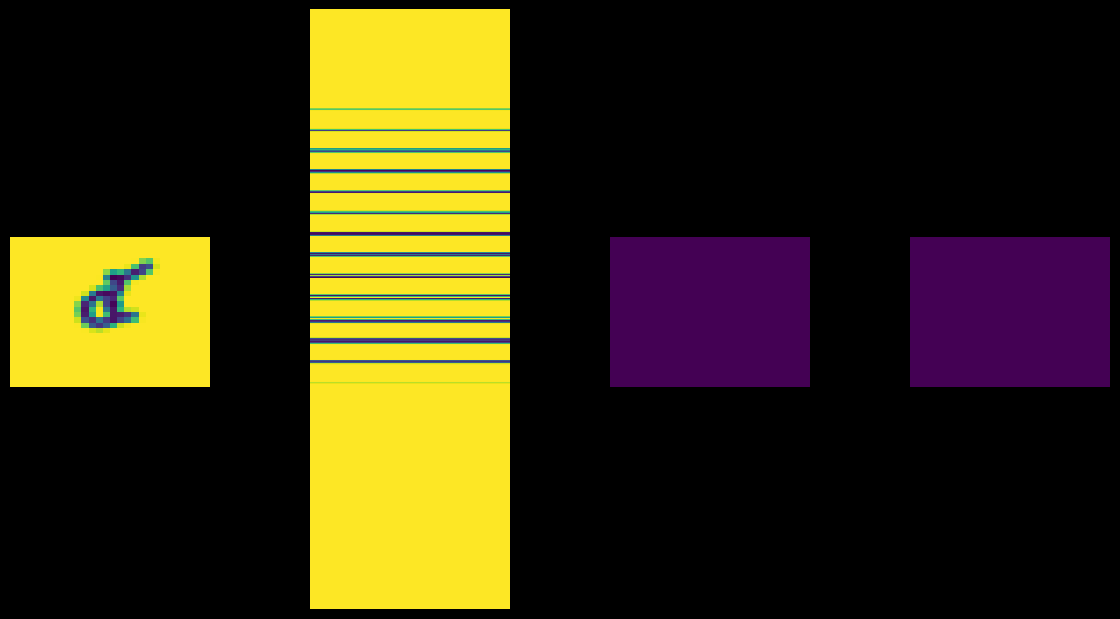

In [148]:
show_NN_featuremaps(nn_model.get_features(images[0].unsqueeze(0).to('cpu')))

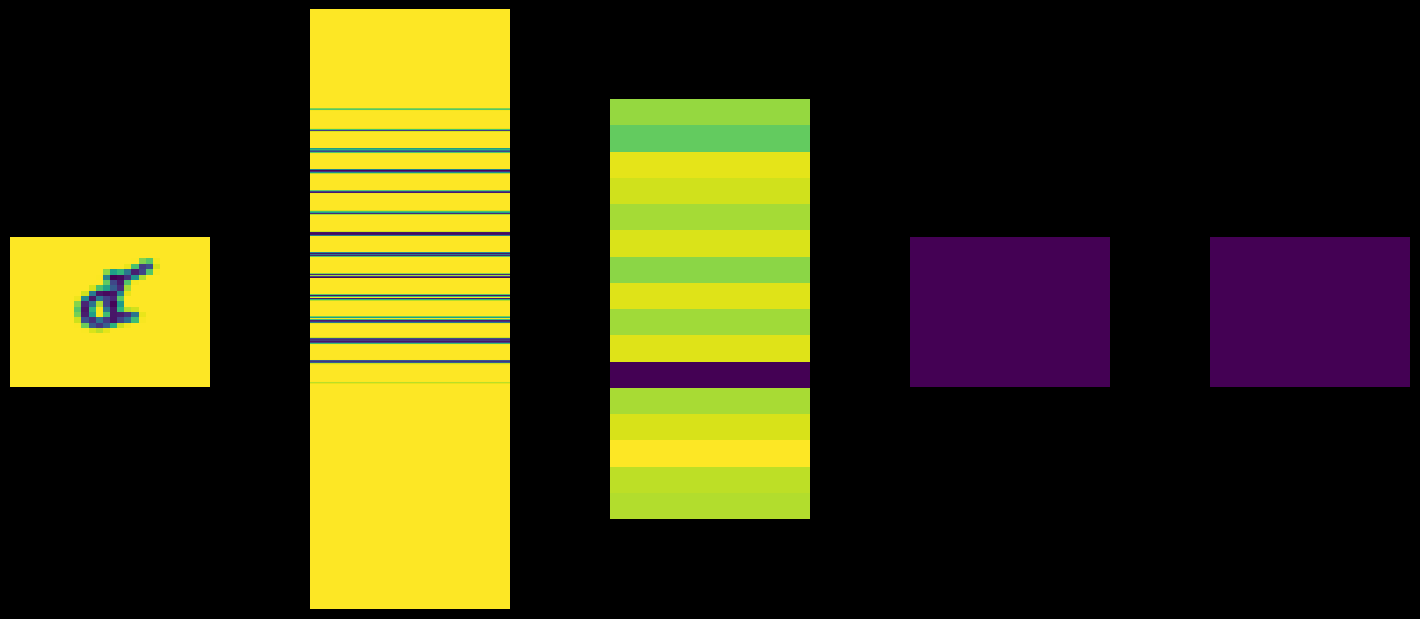

In [156]:
show_MLP_featuremaps(MLP_model.get_features(images[0].unsqueeze(0).to('cpu')))

In [33]:
def show_CNN_featuremaps(feats):
    first_image = feats[0].squeeze().detach().cpu().numpy()
    #craete np array size of 29*size 0f flatten image
    flatten_image = np.tile(feats[2].squeeze().detach().cpu().numpy().flatten(), (1568, 1)).transpose()

    # layer2 = feats[1].unsqueeze(0).detach().cpu().numpy()
    # #craete np array size of 29*size 0f flatten image
    # layer2_image = np.tile(layer2.flatten(), (16, 1)).transpose()
    # Create figure
    fig = plt.figure(figsize=(20, 6), facecolor='black')

    # Add first axes: 28x28 image (taller)
    ax1 = fig.add_axes([0.0, 0.37, 0.10, 0.25])  # [left, bottom, width, height]
    sns.heatmap(first_image, ax=ax1, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax1.axis('off')

    # Add second axes: 28x784 image (shorter)
    ax2 = fig.add_axes([0.15, 0.05, 0.02, 0.9])  # shorter height
    sns.heatmap(feats[1].squeeze(0).view(-1,14).detach().numpy(), ax=ax2, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax2.axis('off')

    ax3 = fig.add_axes([0.30, 0.05, 0.02, 0.9])  # shorter height
    sns.heatmap(feats[2].squeeze(0).view(-1,7).detach().numpy(), ax=ax3, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax3.axis('off')

    ax4 = fig.add_axes([0.45, 0.0, 0.10, 1])  # shorter height
    sns.heatmap(flatten_image, ax=ax4, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax4.axis('off')

    ax5 = fig.add_axes([0.60, 0.3, 0.10, 0.4])  # shorter height
    sns.heatmap(np.tile(feats[3].squeeze().detach().cpu().numpy().flatten(), (100, 1)).transpose(), ax=ax5, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax5.axis('off')

    ax6 = fig.add_axes([0.75, 0.37, 0.10, 0.25])  # shorter height
    sns.heatmap(np.full((28, 28), feats[4].detach().cpu().numpy()[0]), ax=ax6, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax6.axis('off')

    ax7 = fig.add_axes([0.90, 0.37, 0.10, 0.25])  # shorter height
    sns.heatmap(np.full((28, 28), feats[4].detach().cpu().numpy()[0].round()), ax=ax7, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    ax7.axis('off')

    return fig

In [157]:
feats = CNN_model.get_features(images[0].unsqueeze(0).to('cpu'))

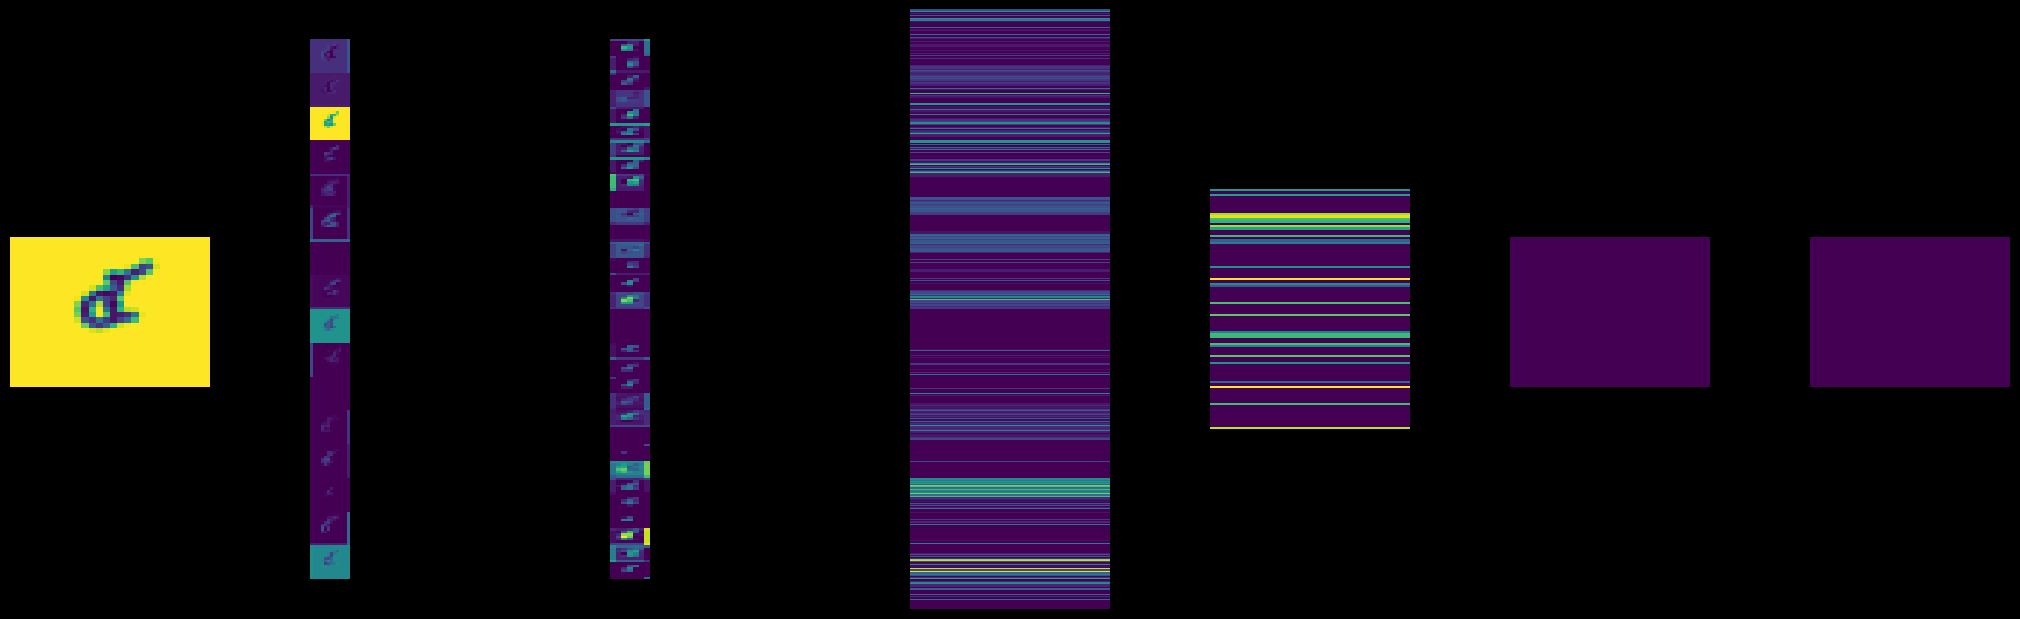

In [177]:
show_CNN_featuremaps(feats)

In [14]:
# Get the first image from the first batch and sent to get_feature oif CNN model
first_image = images[1].unsqueeze(0).to('cpu')  # Add batch dimension
cnn_features = CNN_model.get_features(first_image)

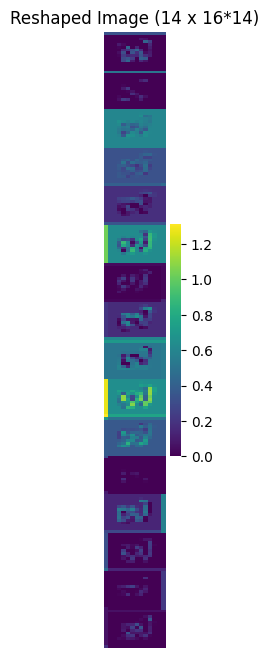

In [28]:
cnn_features[0].shape
feat_0 = cnn_features[0].squeeze(0)  # Remove batch dimension
feat_0_img = feat_0.view(-1,14).detach().numpy()
plt.figure(figsize=(1,8))
sns.heatmap(feat_0_img, cmap='viridis', cbar=True)
plt.axis('off')
plt.title("Reshaped Image (14 x 16*14)")
plt.show()

In [13]:
#Load an image from thai_handwriting-number.appspot.com/0/ and transform it
from PIL import Image
images = []
path = ['0a8e39b3-4d7c-4050-a25d-746a6b8de686','0a8e39b3-4d7c-4050-a25d-746a6b8de686','0a8e39b3-4d7c-4050-a25d-746a6b8de686','1a33cb32-ecd4-461e-a8af-39474c7e40ed','0b48e328-0e73-4946-8fe5-c2324cf55c88','0b620ff8-8d2c-4213-86b0-8a4f67a59712','0b48e328-0e73-4946-8fe5-c2324cf55c88','0a51150d-0afd-455e-9782-9141b68475ed','0b48e328-0e73-4946-8fe5-c2324cf55c88','1a14bb8c-2e61-471e-bf8e-4dc6165497e9']

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(45, fill=255),  # Random rotation for augmentation
    transforms.Pad(padding=2, fill=255, padding_mode='constant'),  # Padding to ensure the image size is 32x32 if needed, fill white
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor()
])
for i in range(10):
    image_path = f'./thai-handwriting-number.appspot.com/{str(i)}/{path[i]}.png'
    image = Image.open(image_path).convert('RGB')  # Load and convert to RGB
    images.append(transform(image).unsqueeze(0))  # Add batch dimension


In [14]:
CNN_model = CNN()
CNN_model.load_state_dict(torch.load('./models/CNN_0_1.pth', map_location='cpu'))
CNN_model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
#close figure


In [ ]:
fig = show_CNN_featuremaps(CNN_model.get_features(images[0]))  # Add batch dimension and send to CPU
writer = SummaryWriter(log_dir='runs/Combination/CNN_0_1')  # Initialize TensorBoard writer
writer.add_figure('CNN Feature Maps', fig, global_step=0)  # Log the figure to TensorBoard
writer.close()
plt.close(fig)  # Close the figure to free memory

AttributeError: 'Figure' object has no attribute 'close'

In [17]:
selector = True
parents = 'runs/Combination/NN'
for i in range(9):
    for j in range(i+1, 10):
        print(f"Processing NN_{i}_{j}")
        model_path = f'./models/NN/NN_{i}_{j}.pth'
        save_path = f'/NN_{i}_{j}'
        writer = SummaryWriter(log_dir=f'{parents}{save_path}')  # Initialize TensorBoard writer
        NN_model = NN()
        NN_model.load_state_dict(torch.load(model_path, map_location='cpu'))
        NN_model.eval()
        if selector:
            image = images[i]
        else:
            image = images[j]
        fig = show_NN_featuremaps(NN_model.get_features(image))
        writer.add_figure(f'NN Feature Maps {i} vs {j}', fig, global_step=0)  # Log the figure to TensorBoard
        writer.close()
        plt.close(fig)
        selector = not selector  # Toggle selector for next iteration
        del NN_model, fig, writer

Processing NN_0_1
Processing NN_0_2
Processing NN_0_3
Processing NN_0_4
Processing NN_0_5
Processing NN_0_6
Processing NN_0_7
Processing NN_0_8
Processing NN_0_9
Processing NN_1_2
Processing NN_1_3
Processing NN_1_4
Processing NN_1_5
Processing NN_1_6
Processing NN_1_7
Processing NN_1_8
Processing NN_1_9
Processing NN_2_3
Processing NN_2_4
Processing NN_2_5
Processing NN_2_6
Processing NN_2_7
Processing NN_2_8
Processing NN_2_9
Processing NN_3_4
Processing NN_3_5
Processing NN_3_6
Processing NN_3_7
Processing NN_3_8
Processing NN_3_9
Processing NN_4_5
Processing NN_4_6
Processing NN_4_7
Processing NN_4_8
Processing NN_4_9
Processing NN_5_6
Processing NN_5_7
Processing NN_5_8
Processing NN_5_9
Processing NN_6_7
Processing NN_6_8
Processing NN_6_9
Processing NN_7_8
Processing NN_7_9
Processing NN_8_9


Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.


# Answers
1. เลขที่มีลักษณะคล้ายกัน เช่น เลข ๓ กับ ๙ จะทำให้โมเดลทำงานได้แย่กว่าเลขอืนๆ แต่เลขที่มีลักษณพที่แตกต่างกันโมเดลจะ predict ได้แม่นกว่าเช่น เลข ๐ กับ ๒
2. เลข ๓ กับ ๙ ทำงานได้แย่ที่สุด feature map เมื่อใส่ input หมายเลข ๓ และ ๙ จะมีลักษณะคล้ายกันจึงทำให้ model แยกเลขได้
3. CNN outperform NN ในทุกกรณี เพราะมี node และ Layer เยอะกว่าทำให้ model สามารถแยกแยะได้ดีกว่า NN ที่มีแค่ Layer เดียว และ CNN จะดู spartial ของ pixel ในภาพด้วย แต่ NN หรือ MLP จะ flatten รูปทำให้เสียโครงสร้างของรูปไปหมด
4. clean data ก่อนจะทำการ train เพราะ dataset ที่อาจารย์ให้มามีบางรูปที่เป็นรูปดำหรือขาวล้วน และทำการ augment เพื่อทำให้ model สามารถรอลรับถาพที่มี noise ได้